# Brain model for decilitated cell

In [1]:
from brian2tools import *
from brian2 import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
from brian2.units.constants import faraday_constant as F
from brian2.units.constants import gas_constant as R
from brian2.units.constants import zero_celsius as temp

In [3]:
import numpy as np
import pandas as pd

In [4]:
prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!


In [5]:
dt = 5e-05 * second
dt

50. * usecond

## Load the data

In [6]:
df_v = pd.read_csv('decilliated_v_pos.csv')
df_ic = pd.read_csv('decilliated_ic_pos.csv')
df_inoise = pd.read_csv('decilliated_i_noise.csv')
df_wn_v = pd.read_csv('decilliated_v_noise.csv')

#### Get V positive

In [7]:
Vout = df_v.to_numpy()
Vout = Vout[:, 2:]

In [8]:
np.shape(Vout)

(20, 22399)

In [9]:
Vout

array([[-0.02855869, -0.02865738, -0.02878897, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02873963, -0.02862449, -0.02873963, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02829552, -0.02832841, -0.02803234, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02564731, -0.02572955, -0.0257131 , ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02439722, -0.02418339, -0.02428208, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.02135425, -0.02138714, -0.02122266, ..., -0.02329517,
        -0.02314713, -0.02311424]])

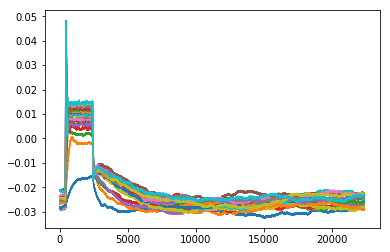

In [10]:
plot(Vout.transpose());

#### Get positive injection current

In [11]:
Ic = df_ic.to_numpy()
Ic = Ic[:, 1:]

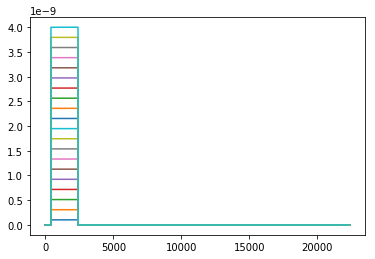

In [12]:
plot(Ic.transpose());

#### Get white noise injection

In [13]:
Inoise = df_inoise.to_numpy()
Inoise = Inoise[:, 1:].transpose()[0]

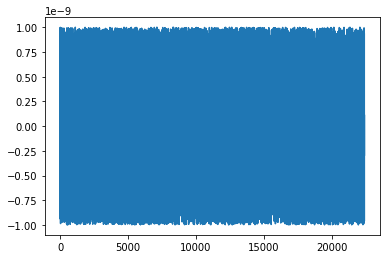

In [14]:
plot(Inoise);

#### Get V from white noise

In [15]:
Vnoise = df_wn_v.to_numpy()
Vnoise = Vnoise[:, 1:].transpose()[0]

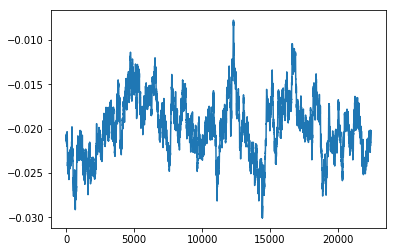

In [16]:
plot(Vnoise);

### Concatinate the data

In [17]:
output = np.concatenate((Vout[:,:10000], [Vnoise[:10000]]))
np.shape(output)

(21, 10000)

In [18]:
input_cur = np.concatenate((Ic[:, :10000], [Inoise[:10000]]))
np.shape(input_cur)

(21, 10000)

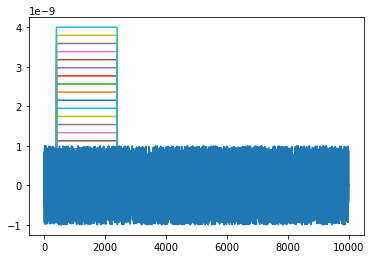

In [19]:
plot(input_cur.transpose());

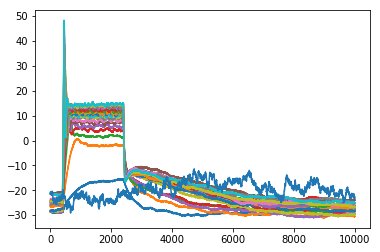

In [20]:
plot((output/1e-3).transpose());

## Define a model

In [21]:
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
I = TimedArray(input_current0, dt=dt)

In [22]:
# exprel(x) = (exp(x)-1)/x
# (abs(v)+0.0001*mV)*sign(v)

In [23]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)* v * ((1-exp(((Ek-v)*F)/(R*T)))/(1-exp((-v*F)/(R*T)))) + I(t))/C: volt
dn/dt = (1-n)*alpha - beta*n : 1

vn = (abs(v-Vn)+0.0001*mV)*sign(v-Vn): volt
alpha = (1/(2 * kn * taun)) * vn/(1-exp(-vn/kn)) : Hz 
beta = -(1/(2 * kn * taun)) * vn/(1-exp(vn/kn)) : Hz 
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
C: farad (constant)
EL: volt (constant)
gL: siemens (constant)
''',
T = temp+20*kelvin,
F = F, 
R = R,              
)

In [24]:
start_scope()

G = NeuronGroup(1, model, method='exponential_euler')
G.set_states({'v': -30*mV})
G.set_states({'g_k': 1, 'kn': 1, 'taun': 1, 'Vn': 1, 'Ek': 1, 'EL':1, 'gL':1, 'C':1}, units=False)

In [25]:
run(10*ms)

In [26]:
G.get_states()

{'N': array(1),
 'i': array([0], dtype=int32),
 't': 10. * msecond,
 'dt': 100. * usecond,
 't_in_timesteps': array(100),
 'v': array([-12.59640598]) * kvolt,
 'n': array([3.44601319e-24]),
 'g_k': array([1.]) * siemens,
 'kn': array([1.]) * volt,
 'taun': array([1.]) * second,
 'Vn': array([1.]) * volt,
 'Ek': array([1.]) * volt,
 'C': array([1.]) * farad,
 'EL': array([1.]) * volt,
 'gL': array([1.]) * siemens}

In [27]:
model = Equations('''
v1 = (abs(v)+0.0001*mV)*sign(v): volt
vn = (abs(v-Vn)+0.0001*mV)*sign(v-Vn): volt

dv/dt = (gL * (EL - v) + g_k*(n)* v * ((1-exp(((Ek-v)*F)/(R*T)))/(1-exp((-v1*F)/(R*T)))) + I)/C: volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * vn/(1-exp(-vn/kn)) : Hz 
beta = -(1/(2 * kn * taun)) * vn/(1-exp(vn/kn)) : Hz 
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
C: farad (constant)
EL: volt (constant)
gL: siemens (constant)
''',
T = temp+20*kelvin,
F = F, 
R = R,              
)

In [28]:
start_scope()
n_opt = NevergradOptimizer(method='PSO')
metric = MSEMetric()

In [29]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

In [30]:
res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=input_cur * amp, output=output * volt, dt=dt,
                        method='exponential_euler',
                        callback=callback,
                        EL=[-50*mV, -10*mV],
                        C=[100*pF, 400*pF],
                        gL=[7*nS, 20*nS],                        
                        kn=[5*mV, 20*mV],
                        Vn=[-20*mV, 20*mV],
                        Ek=[-100*mV, 0*mV],
                        g_k=[1e-1*uS, 1e4*uS],
                        taun=[1*ms, 40*ms],
                        param_init={'v': -30 * mV},
                        n_rounds=55, n_samples=30, optimizer=n_opt, metric=metric)

WARNING    neurons's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurons's variable 'n' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/nevergrad/optimization/base.py:284: UserWarning: Updating fitness with nan value
  warnings.warn(f"Updating fitness with {value} value")
 [py.warnings]


index 0 errors minimum: nan


WARNING    /home/alteska/Desktop/brian/brian2tools/brian2tools/modelfitting/metric.py:152: RuntimeWarning: overflow encountered in square
  mse = sum(square(temp_out - trace))
 [py.warnings]


index 1 errors minimum: nan
index 2 errors minimum: 8.70784424850917
index 3 errors minimum: nan
index 4 errors minimum: 6.841067839998198
index 5 errors minimum: nan
index 6 errors minimum: nan
index 7 errors minimum: nan
index 8 errors minimum: nan
index 9 errors minimum: 2.255140619224796
index 10 errors minimum: 1.8005807517709385
index 11 errors minimum: nan
index 12 errors minimum: 2.9420851775961383
index 13 errors minimum: nan
index 14 errors minimum: nan
index 15 errors minimum: nan
index 16 errors minimum: nan
index 17 errors minimum: 1.6588578192763608
index 18 errors minimum: nan
index 19 errors minimum: nan
index 20 errors minimum: 1.406589166538024
index 21 errors minimum: 1.529385542893473
index 22 errors minimum: 1.4780294433758128
index 23 errors minimum: nan
index 24 errors minimum: 1.408746873832726
index 25 errors minimum: nan
index 26 errors minimum: nan
index 27 errors minimum: 1.3735031484987816
index 28 errors minimum: nan
index 29 errors minimum: 1.370394179601

In [31]:
res

{'kn': 0.005000000000000001,
 'g_k': 9.109590592167559e-05,
 'Vn': 0.01866710791727626,
 'C': 4e-10,
 'Ek': -6.938893903907228e-18,
 'EL': -0.010026987772959878,
 'taun': 0.0010000000000000009,
 'gL': 2e-08}

## visualization of the results

In [32]:
start_scope()
fits = generate_fits(model=model, method='exponential_euler', params=res,
                     input=input_cur * amp, input_var='I', output_var='v',
                     param_init={'v': -30 * mV},
                     dt=dt)

fits/mV

array([[-30.        , -29.95012983, -29.90474141, ..., -25.89989392,
        -25.89989392, -25.89989392],
       [-30.        , -29.95012983, -29.90474141, ..., -25.89989392,
        -25.89989392, -25.89989392],
       [-30.        , -29.95012983, -29.90474141, ..., -25.89989392,
        -25.89989392, -25.89989392],
       ...,
       [-30.        , -29.95012983, -29.90474141, ..., -25.89989392,
        -25.89989392, -25.89989392],
       [-30.        , -29.95012983, -29.90474141, ..., -25.89989392,
        -25.89989392, -25.89989392],
       [-30.        , -29.84539958, -29.73484715, ..., -26.03953341,
        -26.08490078, -25.97380051]])

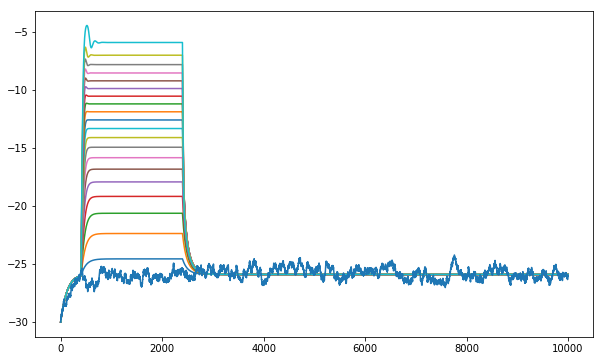

In [33]:
plt.figure(figsize=(10,6))
plot((fits/mV).transpose());

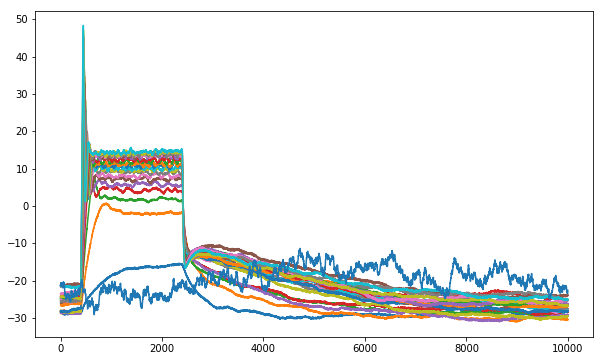

In [34]:
plt.figure(figsize=(10,6))
plot(output.transpose()/1e-3);

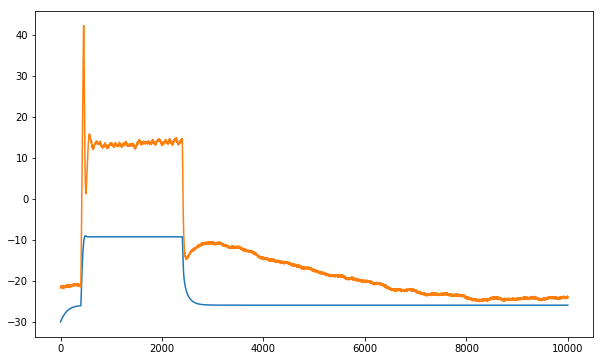

In [35]:
d=15

plt.figure(figsize=(10,6))
plot((fits[d]/mV).transpose());
plot((output[d]/1e-3).transpose());